# Perplexity 


In [1]:
import torch
import numpy as np

# Define neural network architecture
class StressStrainNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1, 50),  # Input: spatial coordinate (x)
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)   # Output: displacement (u)
        )
        
    def forward(self, x):
        return self.layers(x)



In [2]:
def physics_loss(model, x, E, body_force):
    # DELETED LINE - x.requires_grad = True (caused error)
    u = model(x)
    
    du_dx = torch.autograd.grad(u, x, 
              grad_outputs=torch.ones_like(u),
              create_graph=True, 
              retain_graph=True)[0]  # Keep gradients
    
    epsilon = du_dx  # Strain
    sigma = E * epsilon  # Stress
    
    # Equilibrium residual
    dsigma_dx = torch.autograd.grad(sigma, x, 
    
                 grad_outputs=torch.ones_like(sigma),
                 create_graph=True)[0]
    
    residual = dsigma_dx + body_force
    return torch.mean(residual**2)


In [3]:
def boundary_loss(model, L, E, F, A):
    # Fixed displacement boundary (u=0 at x=0)
    x0 = torch.zeros(1, requires_grad=True)
    u0_pred = model(x0)
    bc_loss = u0_pred**2
    
    # Traction boundary (σ=F/A at x=L)
    xL = torch.full((1,1), L, requires_grad=True)
    uL_pred = model(xL)
    du_dx = torch.autograd.grad(uL_pred, xL, 
              grad_outputs=torch.ones_like(uL_pred),
              create_graph=True)[0]
    sigma_pred = E * du_dx
    traction_loss = (sigma_pred - F/A)**2
    
    return bc_loss + traction_loss



In [4]:
# Define material and geometric parameters
E = 200e9  # Young's modulus (Pa)
L = 1.0    # Length of the bar (m)
F = 1000.0 # Applied force (N)
A = 0.01   # Cross-sectional area (m^2)

# Normalize parameters
E = 200e9  # Young's modulus (Pa)
E = E / 1e9  # Scale Young's modulus to GPa
F = F / 1e3  # Scale force to kN
A = A        # Keep area as is


In [ ]:
import time

# Initialize model and optimizer
model = StressStrainNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Start training
start_time = time.time()
for epoch in range(10000):
    optimizer.zero_grad()
    
    # Collocation points - gerating the random points from 0 to L. length of the bar for automatic differentiation
    x = torch.rand(100, 1, requires_grad=True) * L
    
    # Compute losses
    loss_physics = physics_loss(model, x, E, body_force=0)
    loss_bc = boundary_loss(model, L, E, F, A)  # Pass all parameters
    total_loss = loss_physics + loss_bc
    
    # Backpropagation and optimization step
    total_loss.backward()
    optimizer.step()
    
    # Print losses at regular intervals
    if epoch % 1000 == 0 or epoch == 9999:
        elapsed_time = time.time() - start_time
        print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.6f}, "
              f"Physics Loss: {loss_physics.item():.6f}, "
              f"Boundary Loss: {loss_bc.item():.6f}, "
              f"Elapsed Time: {elapsed_time:.2f} seconds")



Epoch: 0, Total Loss: 23228.347656, Physics Loss: 595.276611, Boundary Loss: 22633.070312, Elapsed Time: 58.03 seconds
Epoch: 1000, Total Loss: 0.264706, Physics Loss: 0.264591, Boundary Loss: 0.000115, Elapsed Time: 86.39 seconds
Epoch: 2000, Total Loss: 0.117583, Physics Loss: 0.116950, Boundary Loss: 0.000634, Elapsed Time: 87.22 seconds
Epoch: 3000, Total Loss: 0.026559, Physics Loss: 0.026517, Boundary Loss: 0.000043, Elapsed Time: 88.03 seconds
Epoch: 4000, Total Loss: 0.011690, Physics Loss: 0.011656, Boundary Loss: 0.000034, Elapsed Time: 88.85 seconds
Epoch: 5000, Total Loss: 0.009683, Physics Loss: 0.009442, Boundary Loss: 0.000241, Elapsed Time: 89.67 seconds
Epoch: 6000, Total Loss: 0.008313, Physics Loss: 0.007891, Boundary Loss: 0.000422, Elapsed Time: 90.52 seconds
Epoch: 7000, Total Loss: 0.005526, Physics Loss: 0.004939, Boundary Loss: 0.000587, Elapsed Time: 91.36 seconds
Epoch: 8000, Total Loss: 0.011145, Physics Loss: 0.006054, Boundary Loss: 0.005091, Elapsed Time:

In [6]:
# Normalize parameters

E = 200e9  # Young's modulus (Pa)
E = E / 1e9  # Scale Young's modulus to GPa
F = F / 1e3  # Scale force to kN
A = A        # Keep area as is

# # Normalize x (spatial points)
# x = torch.rand(100, 1, requires_grad=True) * 1.0  # Already normalized (0 to 1)


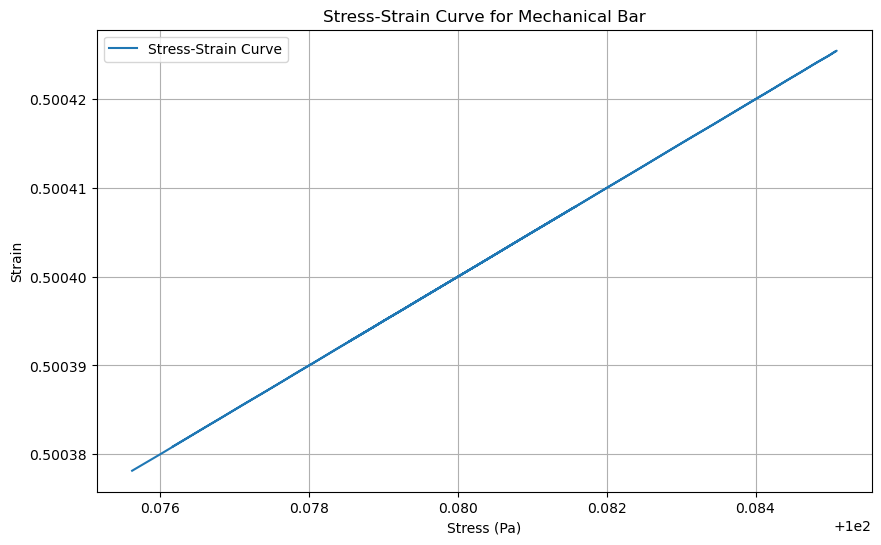

In [7]:
import torch
import matplotlib.pyplot as plt

# Define material and geometric parameters
E = 200e9  # Young's modulus (Pa)
L = 1.0    # Length of the bar (m)
F = 1000.0 # Applied force (N)
A = 0.01   # Cross-sectional area (m^2)

# Normalize parameters
E = 200e9  # Young's modulus (Pa)
E = E / 1e9  # Scale Young's modulus to GPa
F = F / 1e3  # Scale force to kN
A = A        # Keep area as is


# Generate spatial points along the bar
x = torch.linspace(0, L, 100).view(-1, 1).requires_grad_(True)

# Predict displacement using the trained model
u_pred = model(x)

# Compute strain (du/dx)
du_dx = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]

# Compute stress using Hooke's law: σ = E * ε
strain = du_dx.detach().numpy()
stress = (E * strain).flatten()

# Plot stress-strain curve
plt.figure(figsize=(10, 6))
plt.plot(stress, strain, label="Stress-Strain Curve")
plt.xlabel("Stress (Pa)")
plt.ylabel("Strain")
plt.title("Stress-Strain Curve for Mechanical Bar")
plt.legend()
plt.grid(True)
plt.show()
